In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-10-18 01:40:49.357050: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 01:40:50.946668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tempfile

In [3]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity


In [4]:
from tensorflow.keras.models import Sequential, Model

In [5]:
import datetime

In [6]:
#initialise log dir
cur_time = datetime.datetime.now()
cur_time=cur_time.isoformat()[:-7].replace('-','').replace(':','')
logdir = f'logs/{cur_time}'
os.mkdir(logdir)

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-10-18 01:40:54.714939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 01:40:54.801103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 01:40:54.801280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 1. Initialising Dataset

In [8]:
DATASET_ROOT_DIR = "/media/abhishek/data/college/q11/data_science/Incidents-subset-20230213T155459Z-001/incidents-subset_2"
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dir = os.path.join(DATASET_ROOT_DIR, 'trainset')
val_dir = os.path.join(DATASET_ROOT_DIR, 'valset')
test_dir = os.path.join(DATASET_ROOT_DIR, 'testset')

trainset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

valset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)
testset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

Found 4704 files belonging to 12 classes.
Found 1176 files belonging to 12 classes.


2023-10-18 01:40:55.147615: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 01:40:55.147836: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 01:40:55.147945: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 1471 files belonging to 12 classes.


In [9]:
# for i, b in trainset.take(4):
#     print(i.shape)
#     print(b.shape)

['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']


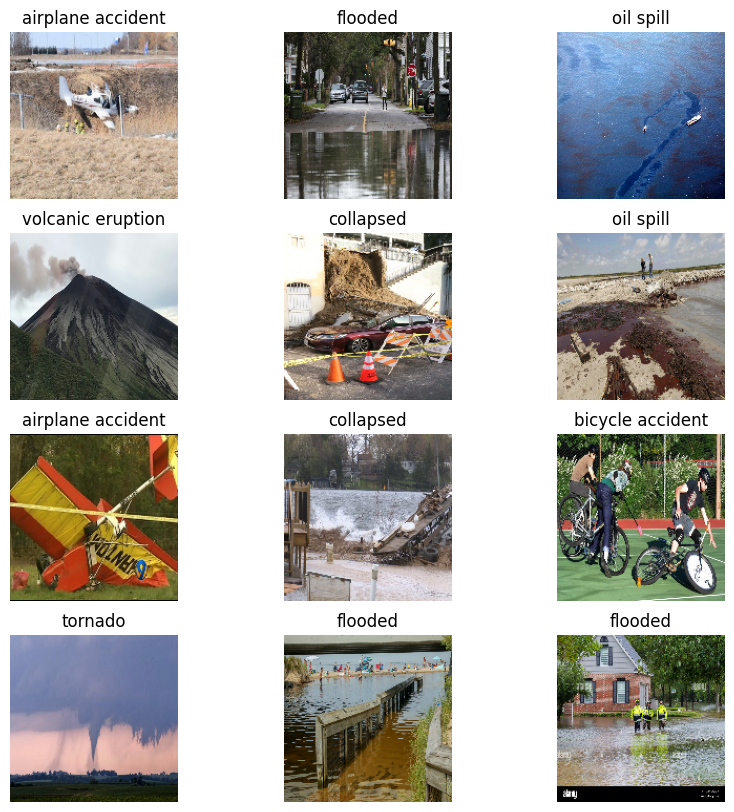

In [9]:
class_names = trainset.class_names
num_classes = len(class_names)
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in trainset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
num_batches = trainset.cardinality().numpy()

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.ignore_errors()
valset = valset.ignore_errors()
testset = testset.ignore_errors()
trainset = trainset.prefetch(buffer_size=AUTOTUNE)
valset = valset.prefetch(buffer_size=AUTOTUNE)
testset = testset.prefetch(buffer_size=AUTOTUNE)

In [12]:
x_train_list = []
y_train_list = []

for p in trainset.as_numpy_iterator():
    x_train_list.append(p[0])
    y_train_list.append(p[1])

X_train = np.concatenate(x_train_list)
y_train = np.concatenate(y_train_list)
print(X_train.shape)
print(y_train.shape)

(4659, 160, 160, 3)
(4659,)


In [13]:
x_test_list = []
y_test_list = []

for p in testset.as_numpy_iterator():
    x_test_list.append(p[0])
    y_test_list.append(p[1])

X_test = np.concatenate(x_test_list)
y_test = np.concatenate(y_test_list)
print(X_test.shape)
print(y_test.shape)

2023-10-18 01:41:34.472242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


(1471, 160, 160, 3)
(1471,)


In [14]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.Adam(lr = 0.0002)

/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'train_accuracy')
train_accuracy = tf.keras.metrics.Accuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name = 'test_accuracy')
test_accuracy = tf.keras.metrics.Accuracy(name = 'test_accuracy')

#### 1.1 Scale Image size to be appropriate for the model

### 2. Create base model from pretrained convnet

In [16]:
#making pruning schedule for conv layers
pruning_curve = []
limit = 0.3
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
pruning_curve = np.round(pruning_curve, 4)
pruning_curve = 1-pruning_curve
print("Percentage of non-zero weights in pruning steps:", pruning_curve)
print("number of pruning steps: ", pruning_curve.shape)

Percentage of non-zero weights in pruning steps: [0.     0.1    0.19   0.271  0.3439 0.4095 0.4686 0.5217 0.5695 0.6126
 0.6513 0.6862]
number of pruning steps:  (12,)


In [17]:
num_pruning_rounds = len(pruning_curve)

In [18]:
def clone_fn_pruning_params(pruning_params):
    
    def clone_layers_mobilenet(layer_i):
        if isinstance(layer_i, tf.keras.layers.Conv2D):
            ret_layer = sparsity.prune_low_magnitude(layer_i, pruning_params, name = layer_i.name)
            # print(layer_i.name, "\t", ret_layer.name)
            # ret_layer.name = layer_i.name
            return ret_layer
        else:
            return layer_i
    return clone_layers_mobilenet

In [19]:
def prune_mobilenet(pruning_round):
    pruning_params_round_i = {
        'pruning_schedule': sparsity.ConstantSparsity(
            target_sparsity=pruning_curve[pruning_round], begin_step=0,
            end_step = end_step, frequency=100
        )
    }
    cloning_fn = clone_fn_pruning_params(pruning_params_round_i)
    pruned_base_model = tf.keras.models.clone_model(base_model, clone_function=cloning_fn)
    return pruned_base_model


In [20]:
batch_size = 60

num_epochs = 100

In [21]:
epochs = num_epochs

end_step = num_batches.astype(np.int32) * epochs

print("'end_step parameter' for this dataset =  {0}".format(end_step))

'end_step parameter' for this dataset =  14700


In [22]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = end_step, frequency=100
    )
}

In [23]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [24]:
image_batch, label_batch = next(iter(trainset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-10-18 01:42:42.637591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(32, 5, 5, 1280)


In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
def pruned_nn(pruning_round):

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # feature_batch_average = global_average_layer(feature_batch)
    # print(feature_batch_average.shape)

    prediction_layer_1 = tf.keras.layers.Dense(128)
    prediction_layer_2 = tf.keras.layers.Dense(num_classes)
    # prediction_batch = prediction_layer_2(prediction_layer_1(feature_batch_average))
    # print(prediction_batch.shape)
    
    # pruned_model = Sequential()

    # # pruned_mobilenet = 
    # pruned_model.add(preprocess_input)
    # pruned_model.add(base_model)
    # pruned_model.add(global_average_layer)
    # pruned_model.add(tf.keras.layers.Dropout(0.2))
    # pruned_model.add(prediction_layer_1)
    # pruned_model.add(prediction_layer_2)

    pruned_base_model = prune_mobilenet(pruning_round)
    
    inputs = tf.keras.Input(shape=(160, 160, 3))
    # x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = pruned_base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = prediction_layer_2(prediction_layer_1(x))
    pruned_model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001
    pruned_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return pruned_model

In [27]:
callback = [
    sparsity.UpdatePruningStep(),
    sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3,
        min_delta=0.001
    )
]

In [28]:
orig_model = pruned_nn(0)
orig_model_stripped = sparsity.strip_pruning(orig_model)
orig_model.save_weights("incidents_lth_random_weights.h5")
orig_model.save_weights("incidents_lth_winning_ticket.h5")

#### 2.1 Feature extraction
Freeze the conv layers

Add classification head


In [29]:
base_model.trainable = True

In [30]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [31]:
prediction_layer_1 = tf.keras.layers.Dense(128)
prediction_layer_2 = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer_2(prediction_layer_1(feature_batch_average))
print(prediction_batch.shape)

(32, 12)


In [32]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer_2(prediction_layer_1(x))
model = tf.keras.Model(inputs, outputs)

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [34]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [35]:
# code from https://www.tensorflow.org/tutorials/images/classification

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

## Create mask

In [36]:
# mask with all 1's

mask_model = pruned_nn(4)
mask_model_stripped = sparsity.strip_pruning(mask_model)
for wts in mask_model_stripped.trainable_weights:
    wts.assign(
        tf.ones_like(
            input = wts,
            dtype = tf.float32
        )
    )

In [37]:
mask_model_2 = pruned_nn(10)
mask_model_stripped_2 = sparsity.strip_pruning(mask_model_2)
for wts in mask_model_stripped_2.trainable_weights:
# for wts in mask_model_2.trainable_weights:
    wts.assign(
        tf.where(
            tf.equal(wts, 0.), 0., 1.
        )
    )

In [38]:
mask_model_stripped_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [39]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0
total_params = 0

for layer in mask_model_stripped.trainable_weights:
    print(tf.size(layer), end="\t")
    print(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    total_params += tf.size(layer)

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))
print("\nTotal number of params in network = {}\n".format(total_params))


Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

tf.Tensor(864, shape=(), dtype=int32)	864
tf.Tensor(32, shape=(), dtype=int32)	32
tf.Tensor(32, shape=(), dtype=int32)	32
tf.Tensor(288, shape=(), dtype=int32)	288
tf.Tensor(32, shape=(), dtype=int32)	32
tf.Tensor(32, shape=(), dtype=int32)	32
tf.Tensor(512, shape=(), dtype=int32)	512
tf.Tensor(16, shape=(), dtype=int32)	16
tf.Tensor(16, shape=(), dtype=int32)	16
tf.Tensor(1536, shape=(), dtype=int32)	1536
tf.Tensor(96, shape=(), dtype=int32)	96
tf.Tensor(96, shape=(), dtype=int32)	96
tf.Tensor(864, shape=(), dtype=int32)	864
tf.Tensor(96, shape=(), dtype=int32)	96
tf.Tensor(96, shape=(), dtype=int32)	96
tf.Tensor(2304, shape=(), dtype=int32)	2304
tf.Tensor(24, shape=(), dtype=int32)	24
tf.Tensor(24, shape=(), dtype=int32)	24
tf.Tensor(3456, shape=(), dtype=int32)	3456
tf.Tensor(144, shape=(), dtype=int32)	144
tf.Tensor(144, shape=(), dtype=int32)	144
tf.Tensor(1296, shape=(), dtype=int32)	1296
tf.Tensor(

In [40]:
print("\nMask model metrics:")
print("layer-wise number of nonzero parameters in each layer are: \n")

masked_sum_params = 0
total_params = 0

layer_wise_total_wts = []
layer_wise_pruned_wts = []

# for layer in mask_model_stripped_2.weights:
#     layer_wise_total_wts.append(tf.size(layer))
#     total_params += tf.size(layer)

for layer in mask_model_stripped_2.trainable_weights:
    
    layer_wise_pruned_wts.append(tf.math.count_nonzero(layer, axis = None).numpy())
    masked_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    layer_wise_total_wts.append(tf.size(layer))
    total_params += (tf.size(layer))

print("num layers total wts:", len(layer_wise_total_wts))
print("num layers pruned wts:", len(layer_wise_pruned_wts))
for i in range(len(layer_wise_total_wts)):
    print(f"{i} \t {layer_wise_total_wts[i]} \t {layer_wise_pruned_wts[i]}\
    \t {layer_wise_pruned_wts[i] / layer_wise_total_wts[i]}")

print("\nTotal number of trainable parameters = {0}\n".format(masked_sum_params))
print("\nTotal number of params in network = {}\n".format(total_params))



Mask model metrics:
layer-wise number of nonzero parameters in each layer are: 

num layers total wts: 160
num layers pruned wts: 160
0 	 864 	 864    	 1.0
1 	 32 	 32    	 1.0
2 	 32 	 32    	 1.0
3 	 288 	 288    	 1.0
4 	 32 	 32    	 1.0
5 	 32 	 32    	 1.0
6 	 512 	 512    	 1.0
7 	 16 	 16    	 1.0
8 	 16 	 16    	 1.0
9 	 1536 	 1536    	 1.0
10 	 96 	 96    	 1.0
11 	 96 	 96    	 1.0
12 	 864 	 864    	 1.0
13 	 96 	 96    	 1.0
14 	 96 	 96    	 1.0
15 	 2304 	 2304    	 1.0
16 	 24 	 24    	 1.0
17 	 24 	 24    	 1.0
18 	 3456 	 3456    	 1.0
19 	 144 	 144    	 1.0
20 	 144 	 144    	 1.0
21 	 1296 	 1296    	 1.0
22 	 144 	 144    	 1.0
23 	 144 	 144    	 1.0
24 	 3456 	 3456    	 1.0
25 	 24 	 24    	 1.0
26 	 24 	 24    	 1.0
27 	 3456 	 3456    	 1.0
28 	 144 	 144    	 1.0
29 	 144 	 144    	 1.0
30 	 1296 	 1296    	 1.0
31 	 144 	 144    	 1.0
32 	 144 	 144    	 1.0
33 	 4608 	 4608    	 1.0
34 	 32 	 32    	 1.0
35 	 32 	 32    	 1.0
36 	 6144 	 6144    	 1.0
3

In [41]:
## Data structure to hold metrics
# Method - 1: Nested Python 3 dictionaries:
history_main = {}

# for x in range(num_pruning_rounds + 1):
for x in range(num_pruning_rounds):
    history = {}
    history['accuracy'] = np.zeros(shape = num_epochs)
    history['val_accuracy'] = np.zeros(shape = num_epochs)
    history['loss'] = np.zeros(shape = num_epochs)
    history['val_loss'] = np.zeros(shape = num_epochs)
    history['percentage_wts_pruned'] = 90

    history_main[x + 1] = history

In [42]:
minimum_delta = 0.001
patience = 3

In [43]:
best_val_loss = 100
loc_patience = 0

## Pruning rounds start

In [45]:
start_time = datetime.datetime.now()

for i in range(1, len(pruning_curve) + 1):
    print(f"\n\nIterative pruning round {i}\n\n")

    @tf.function
    def train_one_step(model, mask_model, optimizer, x, y):
        with tf.GradientTape() as tape:
            y_pred = model(x)
            # print(y.shape)
            # print(y_pred.shape)
            # tf.print(y_pred[0], y[0])
            loss = loss_fn(y, y_pred)
        grads = tape.gradient(loss, model.trainable_variables)
        grad_mask_mul = []
        for grad_layer, mask in zip(grads, mask_model.trainable_weights):
            grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
        optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))
        train_loss(loss)
        train_accuracy(y, tf.argmax(y_pred, axis=1))
        return None

    @tf.function
    def test_step(model, optimizer, data, labels):
        predictions = model(data)
        t_loss = loss_fn(labels, predictions)
        test_loss(t_loss)
        test_accuracy(labels, tf.argmax(predictions, axis = 1))
        return None

    model_gt = pruned_nn(0)
    model_gt.load_weights("incidents_lth_winning_ticket.h5")
    model_gt_stripped = sparsity.strip_pruning(model_gt)

    best_val_loss = 100
    loc_patience = 0

    for epoch in range(num_epochs):
        if loc_patience >= patience:
            print("\n 'Early Stopping' called!\n")
            break

        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        # for x,y in train_dataset:
        for x,y in trainset:
            # print("shape of x and y: ", x.shape, y.shape)
            # y = tf.keras.utils.to_categorical(y, num_classes)
            # print("shape of x and y: ", x.shape, y.shape)
            train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
        # for x_t, y_t in test_dataset:
        for x_t, y_t in testset:
            # print("shape of x_t, y_t: ", x_t.shape, y_t.shape)
            # y_t = tf.keras.utils.to_categorical(y_t, num_classes)
            # print("shape of x_t, y_t: ", x_t.shape, y_t.shape)
            test_step(model_gt_stripped, optimizer, x_t, y_t)
        
        history_main[i]['accuracy'][epoch] = train_accuracy.result() * 100
        history_main[i]['loss'][epoch] = train_loss.result()
        history_main[i]['val_loss'][epoch] = test_loss.result()
        history_main[i]['val_accuracy'][epoch] = test_accuracy.result() * 100
        
        cur_time = datetime.datetime.now()
        print("time since start:", cur_time - start_time)
        
        template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'
        print(template.format(epoch + 1, 
                      train_loss.result(), train_accuracy.result()*100,
                      test_loss.result(), test_accuracy.result()*100))

        
        model_sum_params = 0
    
        for layer in model_gt_stripped.trainable_weights:
            model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
        print("Total number of trainable parameters = {0}\n".format(model_sum_params))
    
        if np.abs(test_loss.result() < best_val_loss) >= minimum_delta:
            best_val_loss = test_loss.result()
            loc_patience = 0
        else:
            loc_patience += 1

    print(f"{epoch} epochs of training done!")
    cur_time = datetime.datetime.now()
    print("time since start:", cur_time - start_time)

    for metrics in history_main[i].keys():
        history_main[i][metrics] = np.resize(history_main[i][metrics], new_shape = epoch)

    model_gt.save_weights("incidents_lth_trained_weights.h5", overwrite=True)
    
    #Prune trained model
    pruned_model = pruned_nn(i)
    pruned_model.load_weights("incidents_lth_trained_weights.h5")
    history_pruned = pruned_model.fit(
        x = X_train, y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        verbose = 1,
        callbacks = callback,
        validation_data = (X_test, y_test),
        shuffle=True
    )

    pruned_model_stripped = sparsity.strip_pruning(pruned_model)

    pruned_sum_params = 0
    for layer in pruned_model_stripped.trainable_weights:
        pruned_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    cur_time = datetime.datetime.now()
    print("time since start:", cur_time - start_time)

    print("\nRound = {0}, total number of trainable parameters = {1}\n".format(i, pruned_sum_params))
    history_main[i]['percentage_wts_pruned'] = ((orig_sum_params - pruned_sum_params) / orig_sum_params) * 100
 
    pruned_model.save_weights("incidents_lth_pruned_weights.h5", overwrite = True)
    
    mask_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    mask_model.load_weights("Conv_2_CIFAR_Pruned_Weights.h5")
    mask_model_stripped = sparsity.strip_pruning(mask_model)
    for wts in mask_model_stripped.trainable_weights:
        wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))
    
    winning_ticket_model = pruned_nn(pruning_params_unpruned, pruning_params_unpruned)
    winning_ticket_model.load_weights("Conv_2_CIFAR_Pruned_Weights.h5")
    winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)
    for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights,
                                    winning_ticket_model_stripped.trainable_weights):
        pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))

    winning_ticket_model.save_weights("incidents_lth_winning_ticket.h5", overwrite=True)
    
    cur_time = datetime.datetime.now()
    print("time since start:", cur_time - start_time)
    print(f"end of pruning round {i}")
    
    with open(logdir + "/incidents_log_file.txt", "a+") as f:
        f.write("Completed iterative pruning round: {0}\n".format(i))
    
    



Iterative pruning round 1




2023-10-18 01:43:56.719371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:00:38.806690
Epoch 1, Loss: 3.1886, Accuracy: 16.7203, Test Loss: 2.5882, Test Accuracy: 19.170633
Total number of trainable parameters = 2389388



2023-10-18 01:44:22.118237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:01:02.810801
Epoch 2, Loss: 2.4977, Accuracy: 18.2013, Test Loss: 2.5688, Test Accuracy: 14.887832
Total number of trainable parameters = 2389388



2023-10-18 01:44:46.148711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:01:26.830497
Epoch 3, Loss: 2.4597, Accuracy: 14.1232, Test Loss: 2.3740, Test Accuracy: 12.780422
Total number of trainable parameters = 2389388



2023-10-18 01:45:10.252896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:01:50.930948
Epoch 4, Loss: 2.4126, Accuracy: 12.1056, Test Loss: 2.4458, Test Accuracy: 9.177430
Total number of trainable parameters = 2389388



2023-10-18 01:45:34.350407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:02:15.033375
Epoch 5, Loss: 2.4249, Accuracy: 9.1436, Test Loss: 2.4779, Test Accuracy: 9.177430
Total number of trainable parameters = 2389388



2023-10-18 01:45:58.333206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


time since start: 0:02:39.024836
Epoch 6, Loss: 2.4199, Accuracy: 9.2724, Test Loss: 2.6957, Test Accuracy: 9.177430
Total number of trainable parameters = 2389388


 'Early Stopping' called!

6 epochs of training done!
time since start: 0:02:39.123970


2023-10-18 01:46:01.583580: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1431244800 exceeds 10% of free system memory.
2023-10-18 01:46:02.577877: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1431244800 exceeds 10% of free system memory.


Epoch 1/100


2023-10-18 01:46:13.104653: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 405.83MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-18 01:46:13.134083: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 144.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-18 01:46:13.160106: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 125.99MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-18 01:46:13.167301: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

NotFoundError: Graph execution error:

Detected at node 'model_5/mobilenetv2_1.00_160/prune_low_magnitude_block_4_expand/Conv2D' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_212964/2732748765.py", line 99, in <module>
      history_pruned = pruned_model.fit(
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
      y_pred = self(x, training=True)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 320, in call
      if 'training' in args:
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py", line 323, in call
      return self.layer.call(inputs, **kwargs)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/media/abhishek/data/college/thesis/thesis_with_dr_duc/conda_envs/dlpruning_tf6.yml/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'model_5/mobilenetv2_1.00_160/prune_low_magnitude_block_4_expand/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777344 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng4{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 54169600 bytes.
  Profiling failure on CUDNN engine eng3{k11=2}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 117071872 bytes.
	 [[{{node model_5/mobilenetv2_1.00_160/prune_low_magnitude_block_4_expand/Conv2D}}]] [Op:__inference_train_function_82709]

### 3. Train the model

In [39]:
initial_epochs = 10

loss0, accuracy0 = model_1.evaluate(valset)

37/37 [==============================] - 8s 123ms/step - loss: 3.4653 - accuracy: 0.0944


In [40]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.47
initial accuracy: 0.09


In [41]:
history = model_1.fit(trainset,
                    epochs=initial_epochs,
                    validation_data=valset)

Epoch 1/10


2023-10-12 16:50:27.795715: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9df1ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-12 16:50:27.795737: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T1000 with Max-Q Design, Compute Capability 7.5
2023-10-12 16:50:27.828506: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-12 16:50:28.070587: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      4/Unknown - 23s 138ms/step - loss: 2.9347 - accuracy: 0.1719

2023-10-12 16:50:41.950454: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     19/Unknown - 26s 143ms/step - loss: 2.1085 - accuracy: 0.3405

2023-10-12 16:50:44.108946: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     89/Unknown - 36s 143ms/step - loss: 1.3978 - accuracy: 0.5485

2023-10-12 16:50:54.109031: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


    105/Unknown - 38s 143ms/step - loss: 1.3359 - accuracy: 0.5664

2023-10-12 16:50:56.401518: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 51s 193ms/step - loss: 1.2063 - accuracy: 0.6041 - val_loss: 0.7154 - val_accuracy: 0.7560
Epoch 2/10
  4/146 [..............................] - ETA: 19s - loss: 0.8206 - accuracy: 0.7344

2023-10-12 16:51:10.578454: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 19/146 [==>...........................] - ETA: 18s - loss: 0.7231 - accuracy: 0.7697

2023-10-12 16:51:12.767129: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 89/146 [=================>............] - ETA: 8s - loss: 0.7171 - accuracy: 0.7577

2023-10-12 16:51:22.743262: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


105/146 [====================>.........] - ETA: 5s - loss: 0.7037 - accuracy: 0.7634

2023-10-12 16:51:25.005626: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 173ms/step - loss: 0.6585 - accuracy: 0.7812 - val_loss: 0.6718 - val_accuracy: 0.7857
Epoch 3/10
  4/146 [..............................] - ETA: 19s - loss: 0.4892 - accuracy: 0.8750

2023-10-12 16:51:36.315926: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 19/146 [==>...........................] - ETA: 18s - loss: 0.5354 - accuracy: 0.8191

2023-10-12 16:51:38.516712: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 91/146 [=================>............] - ETA: 7s - loss: 0.5041 - accuracy: 0.8310

2023-10-12 16:51:48.831910: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


106/146 [====================>.........] - ETA: 5s - loss: 0.4907 - accuracy: 0.8379

2023-10-12 16:51:50.964219: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 173ms/step - loss: 0.4700 - accuracy: 0.8446 - val_loss: 0.6300 - val_accuracy: 0.7985
Epoch 4/10
  4/146 [..............................] - ETA: 20s - loss: 0.3759 - accuracy: 0.8984

2023-10-12 16:52:01.963463: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 19/146 [==>...........................] - ETA: 18s - loss: 0.3407 - accuracy: 0.8947

2023-10-12 16:52:04.120191: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 91/146 [=================>............] - ETA: 7s - loss: 0.3163 - accuracy: 0.8963

2023-10-12 16:52:14.405623: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


106/146 [====================>.........] - ETA: 5s - loss: 0.3187 - accuracy: 0.8956

2023-10-12 16:52:16.539319: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 174ms/step - loss: 0.3076 - accuracy: 0.9021 - val_loss: 0.5443 - val_accuracy: 0.8274
Epoch 5/10
  4/146 [..............................] - ETA: 20s - loss: 0.2163 - accuracy: 0.9453

2023-10-12 16:52:27.752086: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 17s - loss: 0.2136 - accuracy: 0.9359

2023-10-12 16:52:30.034640: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 92/146 [=================>............] - ETA: 7s - loss: 0.1940 - accuracy: 0.9385

2023-10-12 16:52:40.291566: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


107/146 [====================>.........] - ETA: 5s - loss: 0.1951 - accuracy: 0.9369

2023-10-12 16:52:42.428491: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 25s 172ms/step - loss: 0.1920 - accuracy: 0.9382 - val_loss: 0.6372 - val_accuracy: 0.8180
Epoch 6/10
  4/146 [..............................] - ETA: 20s - loss: 0.1496 - accuracy: 0.9453

2023-10-12 16:52:53.201432: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 17s - loss: 0.1441 - accuracy: 0.9453

2023-10-12 16:52:55.482772: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 92/146 [=================>............] - ETA: 7s - loss: 0.1814 - accuracy: 0.9443

2023-10-12 16:53:05.784802: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


107/146 [====================>.........] - ETA: 5s - loss: 0.1810 - accuracy: 0.9442

2023-10-12 16:53:07.924115: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 25s 171ms/step - loss: 0.1745 - accuracy: 0.9444 - val_loss: 0.6353 - val_accuracy: 0.8129
Epoch 7/10
  4/146 [..............................] - ETA: 20s - loss: 0.1366 - accuracy: 0.9609

2023-10-12 16:53:18.606884: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 17s - loss: 0.1398 - accuracy: 0.9625

2023-10-12 16:53:20.879301: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 91/146 [=================>............] - ETA: 7s - loss: 0.1586 - accuracy: 0.9451

2023-10-12 16:53:31.084318: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


106/146 [====================>.........] - ETA: 5s - loss: 0.1598 - accuracy: 0.9434

2023-10-12 16:53:33.236980: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 173ms/step - loss: 0.1650 - accuracy: 0.9433 - val_loss: 0.7909 - val_accuracy: 0.8104
Epoch 8/10
  4/146 [..............................] - ETA: 20s - loss: 0.1314 - accuracy: 0.9531

2023-10-12 16:53:44.226916: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 18s - loss: 0.1466 - accuracy: 0.9531

2023-10-12 16:53:46.524215: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 92/146 [=================>............] - ETA: 7s - loss: 0.1224 - accuracy: 0.9609

2023-10-12 16:53:56.854171: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


107/146 [====================>.........] - ETA: 5s - loss: 0.1162 - accuracy: 0.9620

2023-10-12 16:53:58.992066: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 172ms/step - loss: 0.1143 - accuracy: 0.9605 - val_loss: 0.6151 - val_accuracy: 0.8316
Epoch 9/10
  4/146 [..............................] - ETA: 20s - loss: 0.0880 - accuracy: 0.9688

2023-10-12 16:54:09.732014: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 19/146 [==>...........................] - ETA: 18s - loss: 0.1174 - accuracy: 0.9556

2023-10-12 16:54:11.906072: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 91/146 [=================>............] - ETA: 7s - loss: 0.1164 - accuracy: 0.9619

2023-10-12 16:54:22.219219: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


106/146 [====================>.........] - ETA: 5s - loss: 0.1119 - accuracy: 0.9631

2023-10-12 16:54:24.358346: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 173ms/step - loss: 0.0985 - accuracy: 0.9676 - val_loss: 0.8191 - val_accuracy: 0.7951
Epoch 10/10
  4/146 [..............................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9297

2023-10-12 16:54:35.363397: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 20/146 [===>..........................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9469

2023-10-12 16:54:37.647664: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 92/146 [=================>............] - ETA: 7s - loss: 0.1102 - accuracy: 0.9637

2023-10-12 16:54:47.971208: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


107/146 [====================>.........] - ETA: 5s - loss: 0.1062 - accuracy: 0.9641

2023-10-12 16:54:50.105613: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


146/146 [==============================] - 26s 174ms/step - loss: 0.1000 - accuracy: 0.9654 - val_loss: 0.6839 - val_accuracy: 0.8308


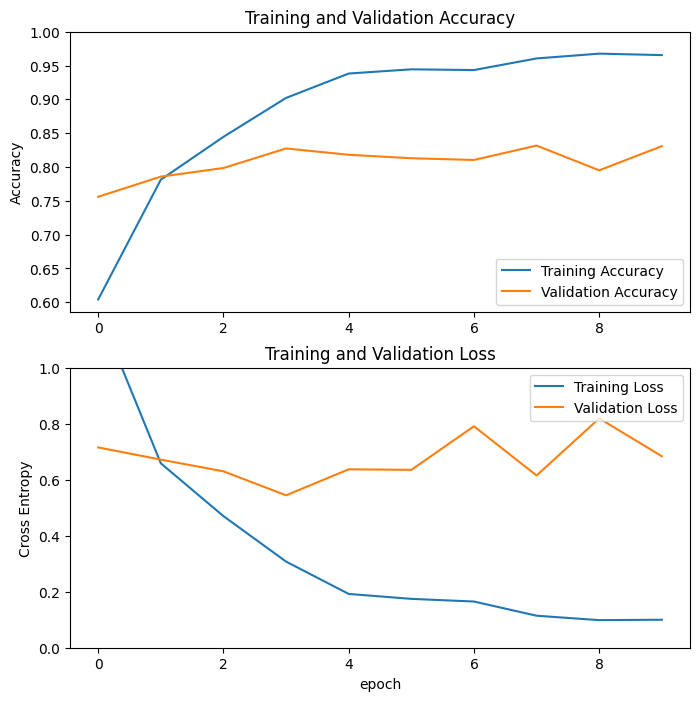

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:

model.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [33]:
base_model_trained = model.layers[3]
base_model_trained = sparsity.prune_low_magnitude(base_model_trained)
base_model_trained.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [ ]:
base_model_trained.summary()

In [23]:
#Understanding base model

conv_layers_full_size = {}

for layer in base_model.layers:
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        # print(layer.name, end="\t")
        # print(layer.count_params())
        conv_layers_full_size[layer.name] = layer.count_params()
        # print(tf.math.count_nonzero(layer.trainable_weights, axis=None))

print()
print(conv_layers_full_size)
print(sum(conv_layers_full_size.values()))


{'Conv1': 864, 'expanded_conv_project': 512, 'block_1_expand': 1536, 'block_1_project': 2304, 'block_2_expand': 3456, 'block_2_project': 3456, 'block_3_expand': 3456, 'block_3_project': 4608, 'block_4_expand': 6144, 'block_4_project': 6144, 'block_5_expand': 6144, 'block_5_project': 6144, 'block_6_expand': 6144, 'block_6_project': 12288, 'block_7_expand': 24576, 'block_7_project': 24576, 'block_8_expand': 24576, 'block_8_project': 24576, 'block_9_expand': 24576, 'block_9_project': 24576, 'block_10_expand': 24576, 'block_10_project': 36864, 'block_11_expand': 55296, 'block_11_project': 55296, 'block_12_expand': 55296, 'block_12_project': 55296, 'block_13_expand': 55296, 'block_13_project': 92160, 'block_14_expand': 153600, 'block_14_project': 153600, 'block_15_expand': 153600, 'block_15_project': 153600, 'block_16_expand': 153600, 'block_16_project': 307200, 'Conv_1': 409600}
2125536


In [48]:
conv_layers_pruning_steps = {}

i = 0
for k,v in conv_layers_full_size.items():
    
    i+=1
    if i > 17:
        print(list(conv_layers_full_size.keys())[i])
        original_size = v
        step_k_size = original_size
        while step_k_size > original_size / 1       

block_9_expand
block_9_project
block_10_expand
block_10_project
block_11_expand
block_11_project
block_12_expand
block_12_project
block_13_expand
block_13_project
block_14_expand
block_14_project
block_15_expand
block_15_project
block_16_expand
block_16_project
Conv_1


IndexError: list index out of range

In [53]:
pruning_curve = []
limit = 0.09
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
np.round(pruning_curve, 3)
pruning_curve.shape

(23,)

In [44]:
len(conv_layers_full_size)

35

### 4. Fine tuning
Unfreeze the top layers

In [28]:
base_model.trainable = True


In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154
